In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -U pip
!pip install torch biopython numpy matplotlib scikit-learn scipy

In [ ]:
!pip install spacy

In [ ]:

!pip install fair-esm



# Data Preprocessing

# Dataset and DataLoader Definition

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import numpy as np
import re
import esm  # Import ESM

train_fasta_path = "/content/drive/MyDrive/Bioinformatics/train.fasta"  # Corrected path
test_fasta_path = "/content/drive/MyDrive/Bioinformatics/test.fasta"  # Corrected path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Define device early
model_name = "esm2_t6_8M_UR50D"  # Smaller model. Adjust as needed.
model, alphabet = esm.pretrained.load_model_and_alphabet(model_name) # Load for embedding dimension
embedding_dim = model.embed_dim
del model # Free up memory


class PadSequence:
    def __call__(self, batch):
        sorted_batch = sorted(batch, key=lambda x: x[0].shape[0], reverse=True)
        sequences = [x[0] for x in sorted_batch]
        sequences_padded = pad_sequence(sequences, batch_first=True)
        lengths = torch.tensor([len(x) for x in sequences])
        labels = np.array([x[1] for x in sorted_batch]) #Convert to single NumPy array
        labels = torch.from_numpy(labels).float() #Convert to tensor efficiently
        return sequences_padded, lengths, labels


class cazySeq(Dataset):
    def __init__(self, seq_file, kmer=6, stride=2, model_name=model_name, device=device):
        self.cate2label = {'GH': 0, 'GT': 1, 'PL': 2, 'CE': 3, 'AA': 4, 'CBM': 5}
        self.cateNums = len(self.cate2label)
        self.seq, self.seqLabel = self.readSeq(seq_file)
        self.kmer = kmer; self.stride = stride
        self.model, self.alphabet = esm.pretrained.load_model_and_alphabet(model_name)
        self.model = self.model.to(device)
        self.model.eval()
        self.batch_converter = self.alphabet.get_batch_converter()
        self.device = device


    def __len__(self):
        return len(self.seq)

    def __getitem__(self, index):
        label = np.zeros(self.cateNums, dtype=np.float32)
        for each_label in self.seqLabel[index]:
            label[each_label] = 1.
        seq_tensor = self.tensorFromSeq(self.seq[index])
        return seq_tensor, label

    def readSeq(self, seq_file):
        seqList = []; seqLabelList = []
        matchPtn = r'^GH|^GT|^PL|^CE|^AA|^CBM'
        for seq_record in SeqIO.parse(seq_file, "fasta"):
            seqList.append(str(seq_record.seq).upper())
            seqId = seq_record.id.split('|')[1:]
            matchedList = []
            for eachId in seqId:
                matchedList.extend(re.findall(matchPtn, eachId))
            matchedSet = set(matchedList)
            seqLabelList.append([self.cate2label[each_cat] for each_cat in matchedSet])
        return seqList, seqLabelList

    def tensorFromSeq(self, seq):
        data = [(str(0), seq)]
        batch_labels, batch_strs, batch_tokens = self.batch_converter(data)
        batch_tokens = batch_tokens.to(self.device)

        with torch.no_grad():
            results = self.model(batch_tokens, repr_layers=[self.model.num_layers], return_contacts=False)
        seq_tensor = results["representations"][self.model.num_layers][0, 1:, :]
        return seq_tensor


In [ ]:
from torch import nn, optim
class ConvLstm(nn.Module):
    def __init__(self, learning_rate, embedding_dim):
        super(ConvLstm, self).__init__()
        self.kernel_size_1 = 2
        self.pool_size_1 = 2
        self.convPool1 = nn.Sequential(
            nn.Conv1d(embedding_dim, 30, self.kernel_size_1),  # Adjust here to match embedding dim
            nn.ReLU(True),
            nn.MaxPool1d(self.pool_size_1, self.pool_size_1)
        )
        self.drop1 = nn.Dropout(0.2)

        self.kernel_size_2 = 1
        self.pool_size_2 = 2
        self.convPool2 = nn.Sequential(
            nn.Conv1d(30, 30, self.kernel_size_2), nn.ReLU(True), nn.MaxPool1d(self.pool_size_2, self.pool_size_2)
        )
        self.drop2 = nn.Dropout(0.2)

        self.BiLstm = nn.LSTM(input_size=30, hidden_size=30, num_layers=1, batch_first=True, bidirectional=True)
        self.lstmdrop = nn.Dropout(0.2)
        self.fc1 = nn.Linear(2 * 30, 32)
        self.fcdrop = nn.Dropout(0.5)

        # Removed self.wq, self.wk, self.wv (attention layers not used in final model)

        self.fc2 = nn.Linear(32, 6)

        self.criterion = nn.MultiLabelSoftMarginLoss()
        self.optimier = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x, seq_lengths):
        x = x.permute(0, 2, 1)
        x = self.convPool1(x)
        x = self.drop1(x)

        x = self.convPool2(x)
        x = self.drop2(x)

        x = x.permute(0, 2, 1)
        _, (x, _) = self.BiLstm(x)
        x = x.permute(1, 0, 2)  # Correct permutation for BiLSTM output
        x = self.lstmdrop(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)


        x = self.fcdrop(x)  # Dropout after FC layer
        x = self.fc2(x)
        return x


# Training and Evaluation Functions

In [ ]:
import math
import torch.nn.functional as F
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

def train(model, dataloader, epochs):
    loss_trace = {'x': [], 'loss': []}
    batch_nums = math.ceil(len(dataloader.dataset) / dataloader.batch_size)

    for epoch in range(epochs):
        for i, (seq, lengths, label) in enumerate(dataloader): # Unpack all three values
            seq, lengths, label = seq.to(device), lengths.to(device), label.to(device) #Move tensors to the device
            output = model(seq, lengths)
            loss = model.criterion(output, label)
            model.optimier.zero_grad()
            loss.backward()
            model.optimier.step()

            if i % 1 == 0:
                print('Epoch[{}/{}], \t Batch[{}/{}], \t Loss:{:.6f}'.format(
                    epoch + 1, epochs, i+1, batch_nums, loss.item()))
                loss_trace['x'].append(epoch + (i+1)/batch_nums)
                loss_trace['loss'].append(loss.item())

    return loss_trace

def test(model, dataloader):
    print('*' * 21 + 'Test Model' + '*' * 21)
    model.eval()
    eval_loss = 0.;
    eval_acc = 0.
    aurocl = []
    auprl = []

    for seq, lengths, label in dataloader:  # Unpack all three values here
        seq, lengths, label = seq.to(device), lengths.to(device), label.to(device)  # Move to device

        output = model(seq, lengths) # Pass sequence lengths here
        loss = model.criterion(output, label)
        eval_loss += loss.item() * label.size(0)

        output = torch.sigmoid(output)

        if output.device == 'cpu':
            y_pred = output.detach().numpy().flatten()
            y_true = label.detach().numpy().flatten()
        else:
            y_pred = output.cpu().detach().numpy().flatten()
            y_true = label.cpu().detach().numpy().flatten()

        fpr, tpr, rocth = roc_curve(y_true, y_pred)
        auroc = auc(fpr, tpr)
        precision, recall, prth = precision_recall_curve(y_true, y_pred)
        aupr = auc(recall, precision)
        aurocl.append(auroc)
        auprl.append(aupr)
        _, pred = torch.max(output, 1)
        for i, each_label in enumerate(label):
            if each_label[pred[i]] == 1:
                eval_acc += 1

    eval_loss /= len(dataloader.dataset)
    eval_acc /= len(dataloader.dataset)
    aurocl = np.array(aurocl)
    auprl = np.array(auprl)
    # print('Test Loss: {:.6f}, Acc: {:.6f}'.format(
    #     eval_loss/len(dataLoader.dataset), eval_acc/len(dataLoader.dataset)))

    # return the loss and accuracy of test dataset
    print("===Final result===")
    print('AUROC= %.4f +- %.4f | AUPR= %.4f +- %.4f' % (aurocl.mean(),aurocl.std(),auprl.mean(),auprl.std()))
    return eval_loss, eval_acc, aurocl, auprl

In [ ]:
from Bio import SeqIO
# Main Execution Block
batch_size = 64
learning_rate = 2e-3
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_fasta_path = "/content/drive/MyDrive/Bioinformatics/train.fasta"
test_fasta_path = "/content/drive/MyDrive/Bioinformatics/test.fasta"

train_data = cazySeq(train_fasta_path, kmer=6, stride=2, model_name=model_name, device=device)
trainIter = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=PadSequence(), num_workers=0)

test_data = cazySeq(test_fasta_path, kmer=6, stride=2, model_name=model_name, device=device)
testIter = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=PadSequence(), num_workers=0)


model = ConvLstm(learning_rate, embedding_dim).to(device)
loss_history = train(model, trainIter, num_epochs)



Epoch[1/5], 	 Batch[1/59], 	 Loss:0.690678
Epoch[1/5], 	 Batch[2/59], 	 Loss:0.682864
Epoch[1/5], 	 Batch[3/59], 	 Loss:0.671514
Epoch[1/5], 	 Batch[4/59], 	 Loss:0.660212
Epoch[1/5], 	 Batch[5/59], 	 Loss:0.642780
Epoch[1/5], 	 Batch[6/59], 	 Loss:0.638480
Epoch[1/5], 	 Batch[7/59], 	 Loss:0.628341
Epoch[1/5], 	 Batch[8/59], 	 Loss:0.607282
Epoch[1/5], 	 Batch[9/59], 	 Loss:0.587186
Epoch[1/5], 	 Batch[10/59], 	 Loss:0.572390
Epoch[1/5], 	 Batch[11/59], 	 Loss:0.551582
Epoch[1/5], 	 Batch[12/59], 	 Loss:0.505809
Epoch[1/5], 	 Batch[13/59], 	 Loss:0.488758
Epoch[1/5], 	 Batch[14/59], 	 Loss:0.479750
Epoch[1/5], 	 Batch[15/59], 	 Loss:0.458337
Epoch[1/5], 	 Batch[16/59], 	 Loss:0.428758
Epoch[1/5], 	 Batch[17/59], 	 Loss:0.435064
Epoch[1/5], 	 Batch[18/59], 	 Loss:0.398484
Epoch[1/5], 	 Batch[19/59], 	 Loss:0.412507
Epoch[1/5], 	 Batch[20/59], 	 Loss:0.378477
Epoch[1/5], 	 Batch[21/59], 	 Loss:0.363689
Epoch[1/5], 	 Batch[22/59], 	 Loss:0.380592
Epoch[1/5], 	 Batch[23/59], 	 Loss:0.3864

*********************Test Model*********************
===Final result===
AUROC= 0.9682 +- 0.0124 | AUPR= 0.8987 +- 0.0369


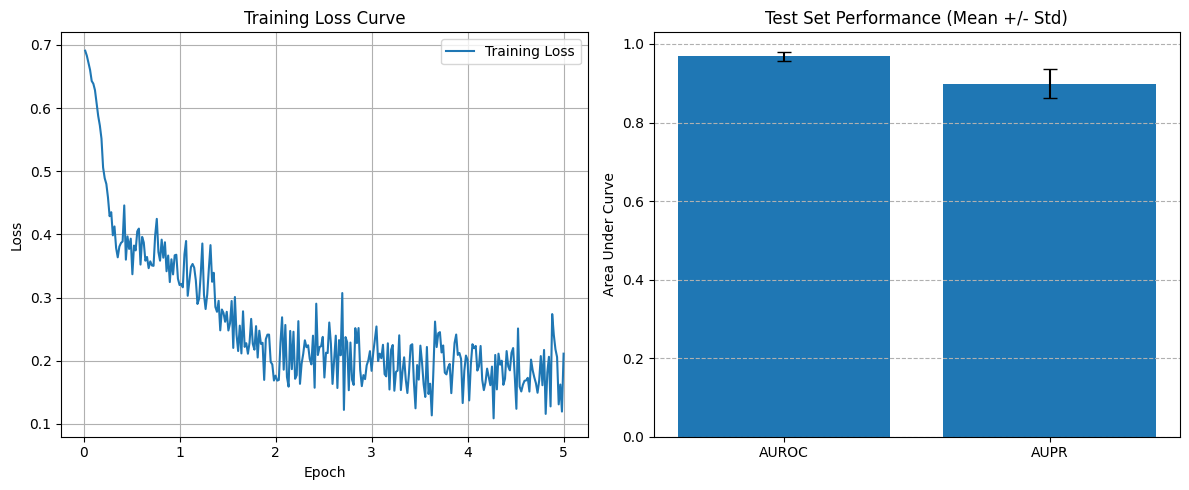

In [ ]:
eval_loss, eval_acc, aurocl, auprl = test(model, testIter)


plt.figure(figsize=(12, 5))  # Adjust figure size for better layout

plt.subplot(1, 2, 1)  # First subplot for loss curve
plt.plot(loss_history['x'], loss_history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)  # Second subplot for AUROC and AUPR

plt.bar(['AUROC', 'AUPR'], [aurocl.mean(), auprl.mean()], yerr=[aurocl.std(), auprl.std()], capsize=5)
plt.ylabel('Area Under Curve')
plt.title('Test Set Performance (Mean +/- Std)')
plt.grid(axis='y', linestyle='--')


plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()